# Multimodal RAG with ColQwen2, Reranker, and Quantized VLMs on Consumer GPUs

Original author: [Sergio Paniego](https://github.com/sergiopaniego)_

In this notebook, we demonstrate how to build a **Multimodal Retrieval-Augmented Generation (RAG)** system by integrating [**ColQwen2**](https://huggingface.co/vidore/colqwen2-v1.0) for document retrieval, [**MonoQwen2-VL-v0.1**](https://huggingface.co/lightonai/MonoQwen2-VL-v0.1) for reranking, and [**Qwen2-VL**](https://qwenlm.github.io/blog/qwen2-vl/) as the vision language model (VLM). Together, these models form a powerful RAG system that enhances query responses by seamlessly combining text-based documents and visual data. Notably, this notebook is optimized for use on a single consumer GPU, thanks to the integration of a quantized VLM.

Instead of relying on a complex OCR-based document processing pipeline, we leverage a **Document Retrieval Model** to efficiently retrieve the most relevant documents based on a user’s query, making the system more scalable and efficient.

This notebook builds on the concepts introduced in our previous guide, [**Multimodal Retrieval-Augmented Generation (RAG) with Document Retrieval (ColPali) and Vision Language Models (VLMs)**](https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_vlms). If you haven't reviewed that notebook yet, we recommend doing so before proceeding with this one.

Tested on an L4 GPU.


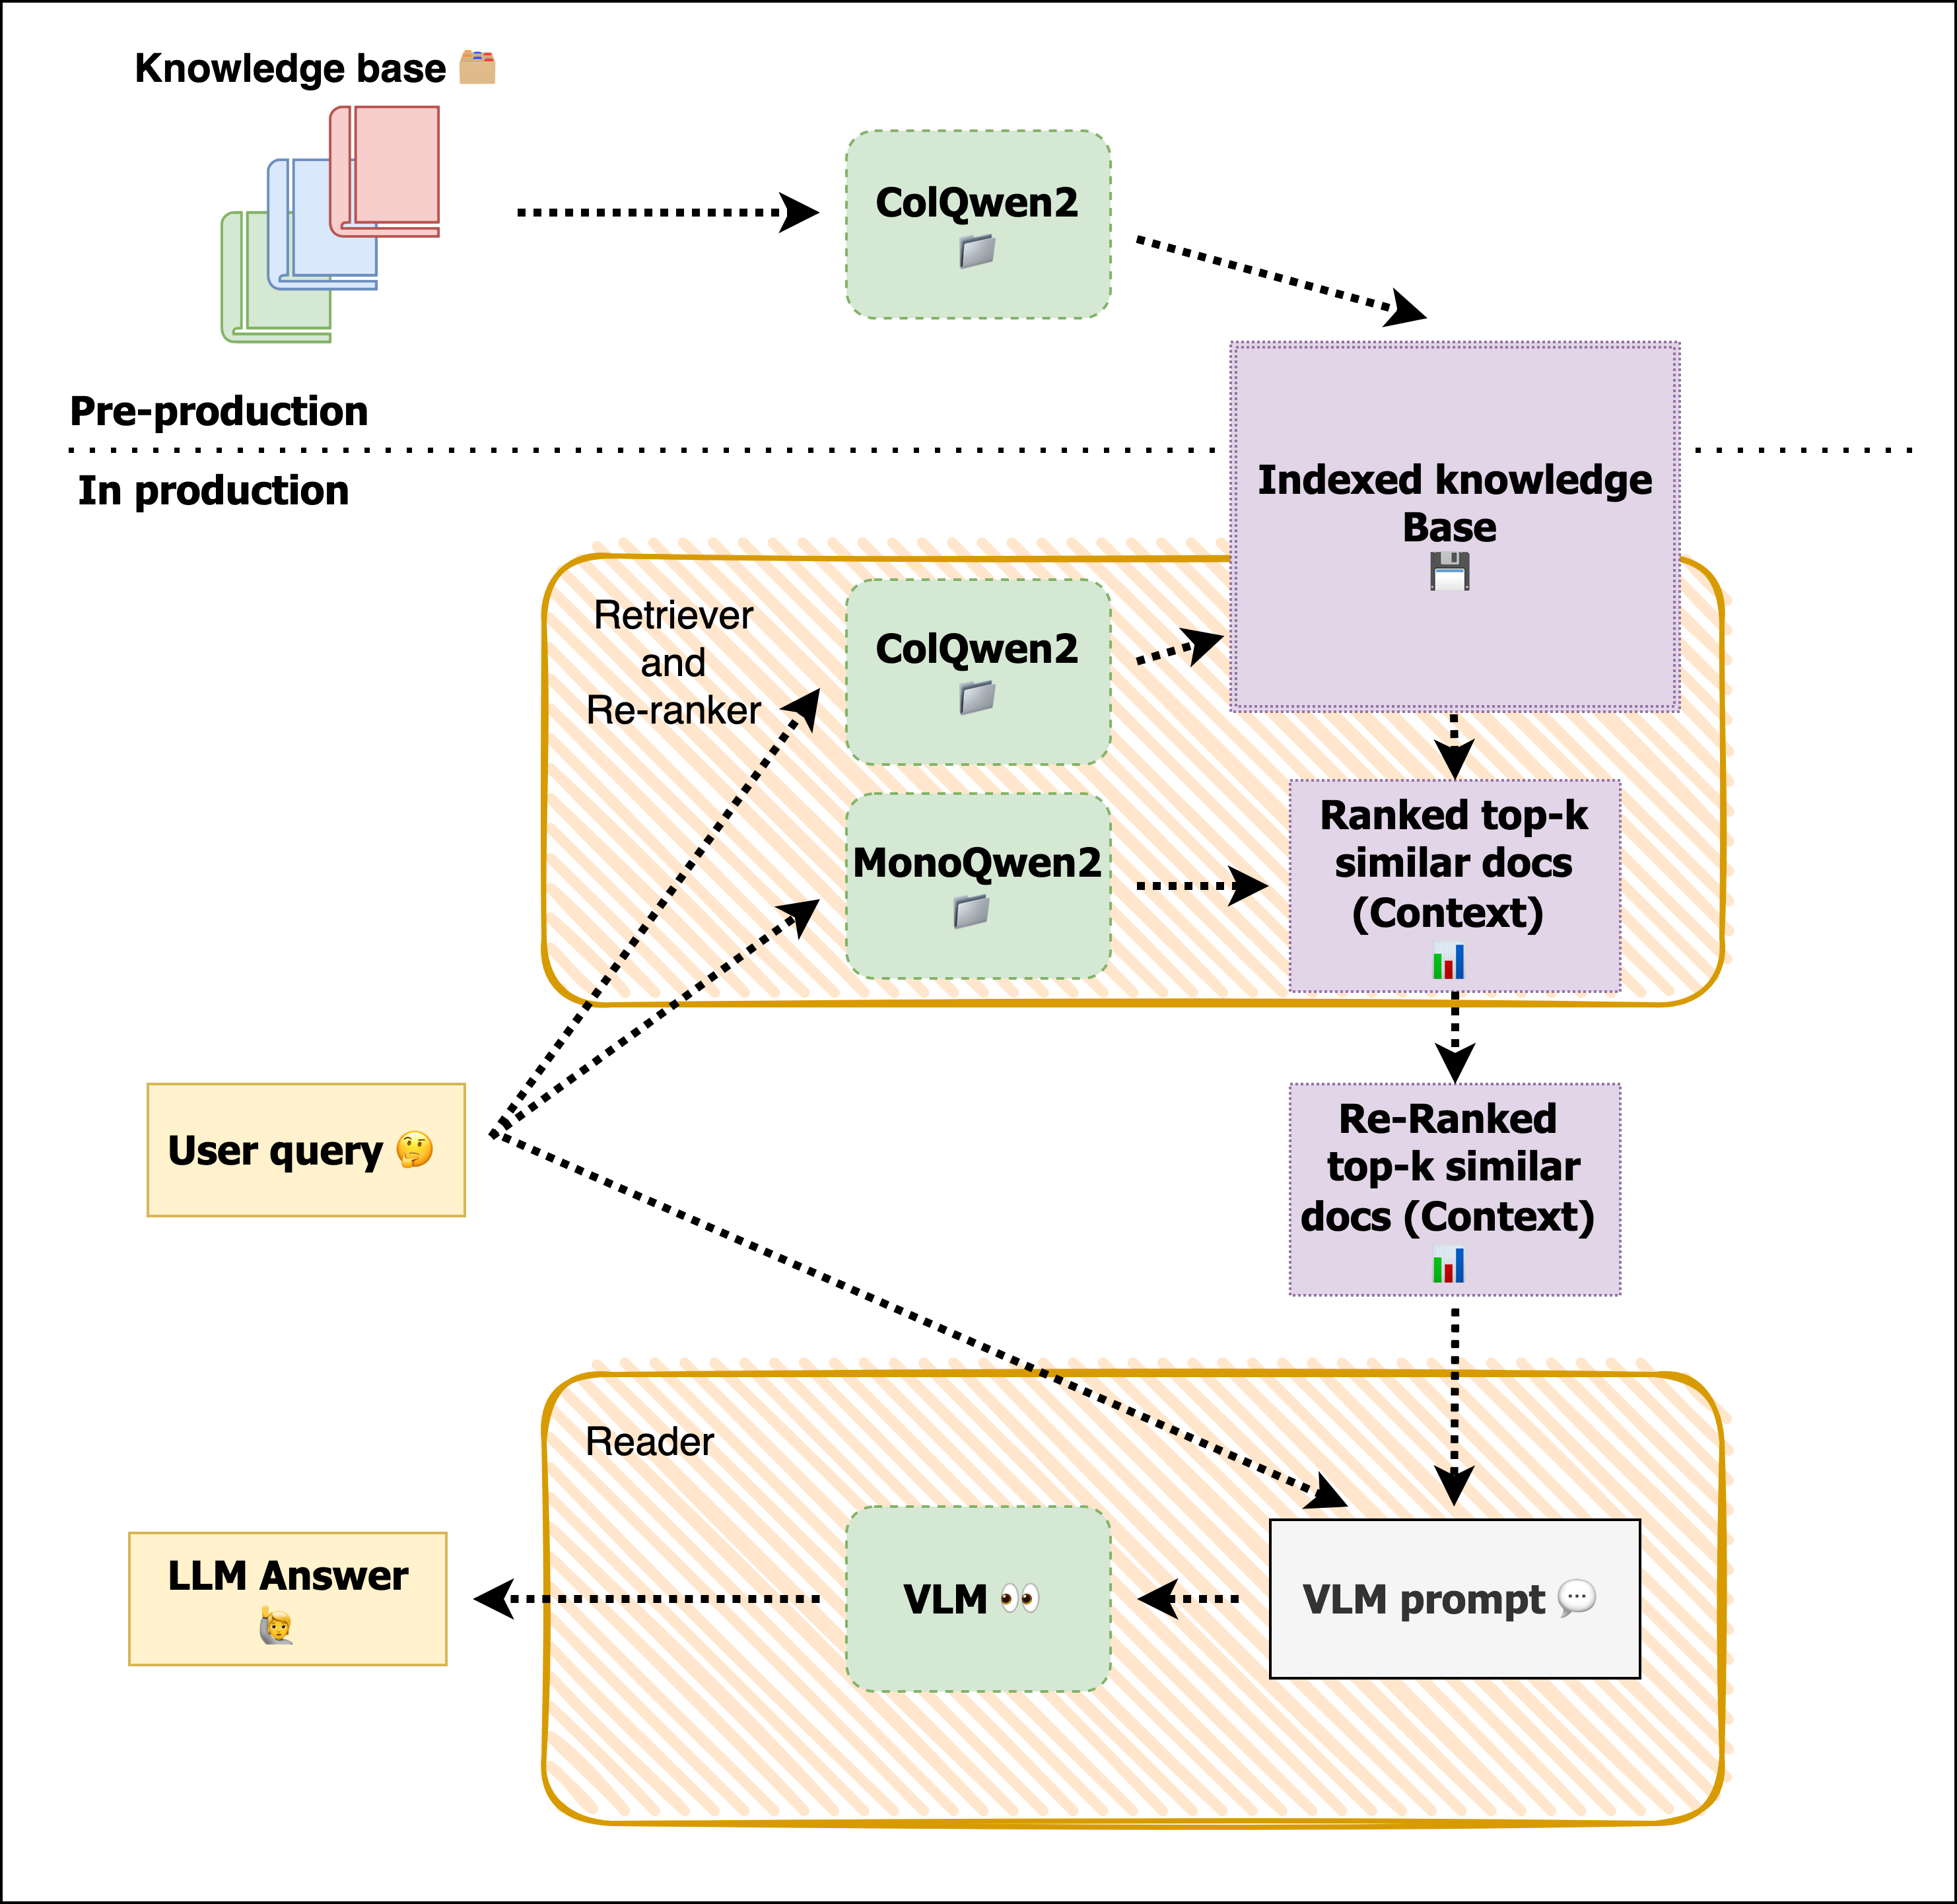

This diagram is inspired by [Aymeric Roucher's](https://huggingface.co/m-ric) work in the [Advanced RAG](https://huggingface.co/learn/cookbook/advanced_rag) or [RAG Evaluation](https://huggingface.co/learn/cookbook/rag_evaluation) recipes.


## 1. Install dependencies

Let’s kick off by installing the essential libraries for our project! 🚀



In [3]:
!pip install -U -q byaldi pdf2image qwen-vl-utils transformers bitsandbytes peft
# Tested with byaldi==0.0.7, pdf2image==1.17.0, qwen-vl-utils==0.0.8, transformers==4.46.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.6 MB/s eta 0:00:00


In [4]:
!pip install pdf2image

In [5]:
!pip install -U -q rerankers[monovlm]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 91.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 3.1 MB/s eta 0:00:00


In [6]:
!pip install python-dateutil

In [7]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [3]:
#!pip install rerankers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 4.0 MB/s eta 0:00:00


After downloading the visual data, we will save it locally to enable the RAG (Retrieval-Augmented Generation) system to index the files later. This step is crucial, as it allows the document retrieval model (ColQwen2) to efficiently process and manipulate the visual content. Additionally, we reduce the image size to **448x448** to further minimize memory consumption and ensure faster processing, which is important for optimizing performance in large-scale operations.



In [8]:
import os
from PIL import Image
from glob import glob
import pdf2image
import numpy as np

input_path = "/content/invoices/*"


def save_images_to_local(input_path, output_folder="/content/preprocessed_invoices/"):
    os.makedirs(output_folder, exist_ok=True)

    for image_id, image_data in enumerate(glob(input_path)):
        print(image_data)
        image = Image.fromarray(np.array(pdf2image.convert_from_path(image_data)[0]))

        image = image.resize((448, 448))

        output_path = os.path.join(output_folder, f"image_{image_id}.png")

        image.save(output_path, format="PNG")

        print(f"Image saved in: {output_path}")


save_images_to_local(input_path)

/content/invoices/tmobile.pdf
Image saved in: /content/preprocessed_invoices/image_0.png
/content/invoices/pravni sluzby k machine learning modelum.pdf
Image saved in: /content/preprocessed_invoices/image_1.png


Now, let's load the images to explore the data and get an overview of the visual content.

In [9]:
import os
from PIL import Image

def load_png_images(image_folder):
    png_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
    all_images = {}

    for image_id, png_file in enumerate(png_files):
        image_path = os.path.join(image_folder, png_file)
        image = Image.open(image_path)
        all_images[image_id] = image
        print(png_file)

    return all_images

all_images = load_png_images("/content/preprocessed_invoices/")

image_1.png
image_0.png


Let’s visualize a few samples to get an understanding of how the data is structured! This will help us grasp the format and layout of the content we’ll be working with. 👀

KeyError: 2

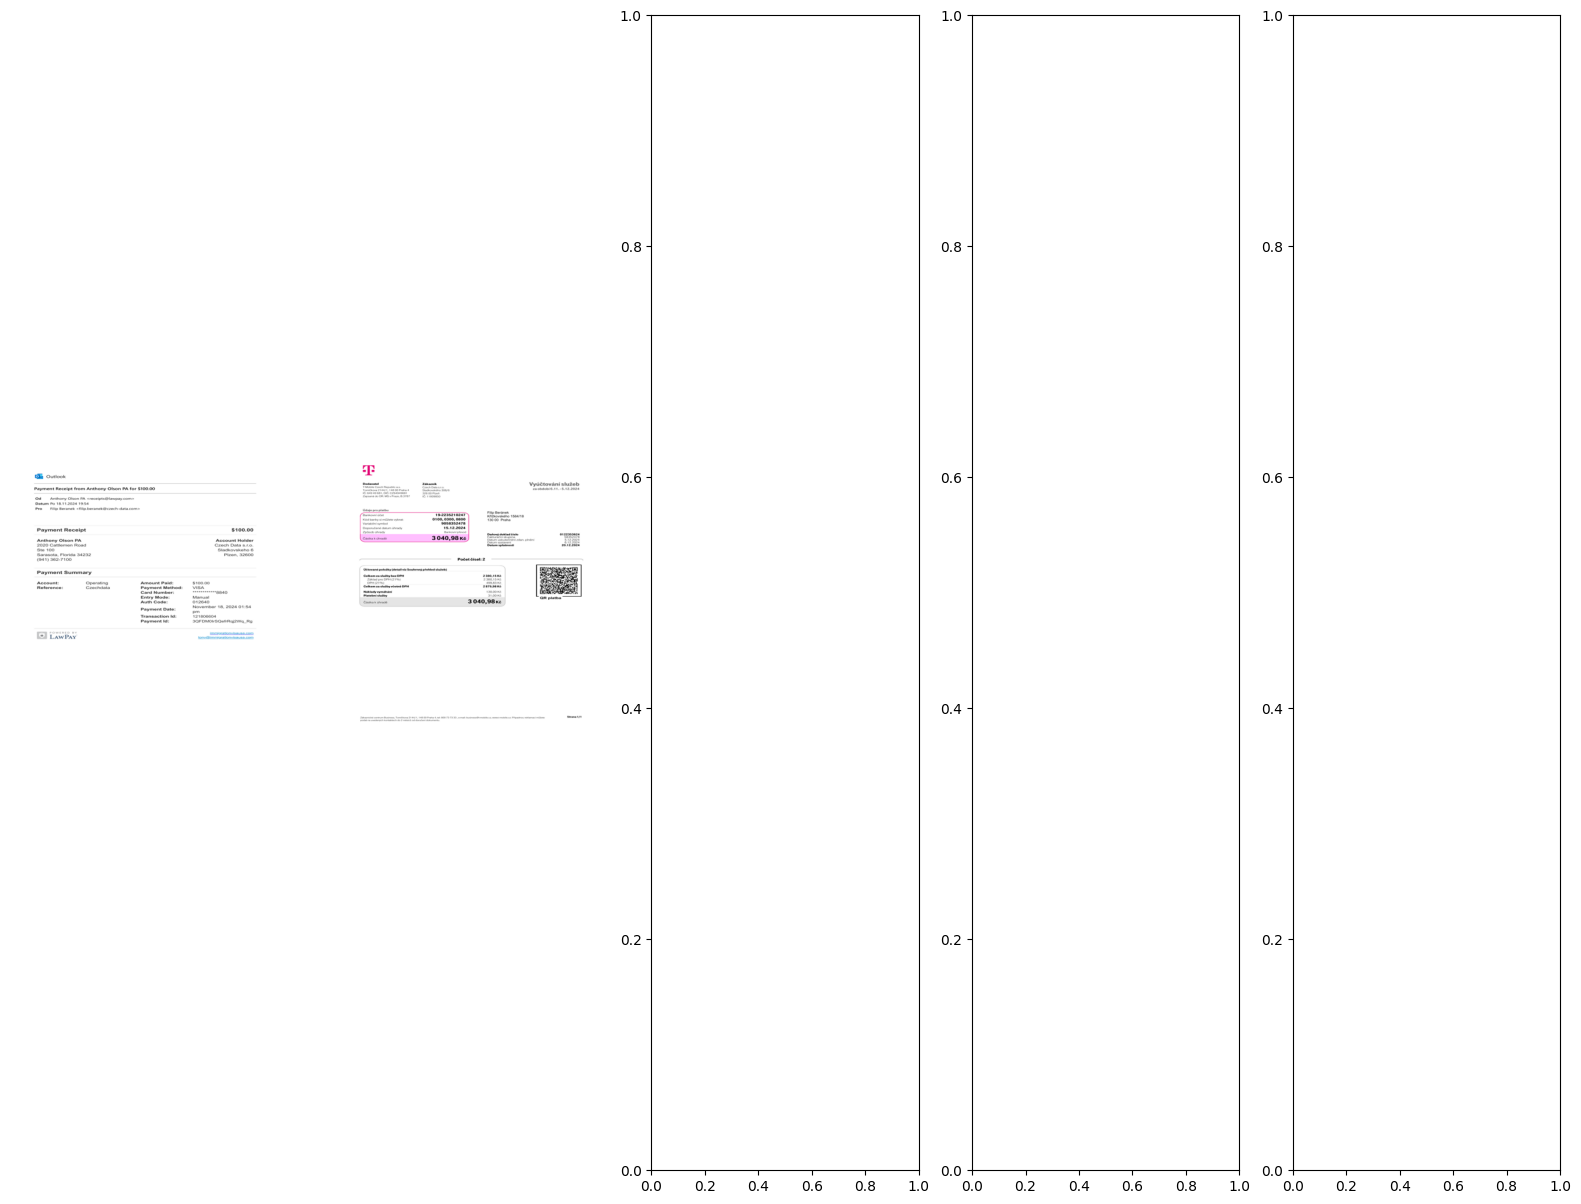

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 15))

for i, ax in enumerate(axes.flat):
    img = all_images[i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Initialize the ColQwen2 Multimodal Document Retrieval Model 🤖


Now that our dataset is ready, we will initialize the Document Retrieval Model, which will be responsible for extracting relevant information from the raw images and delivering the appropriate documents based on our queries.

Using this model, we can greatly enhance our system’s conversational capabilities.

For this task, we will use **[Byaldi](https://github.com/AnswerDotAI/byaldi)**. The developers describe the library as follows: _"Byaldi is RAGatouille's mini sister project. It is a simple wrapper around the ColPali repository to make it easy to use late-interaction multi-modal models such as ColPALI with a familiar API."_

In this project, we will focus specifically on **ColQwen2**.

![ColPali architecture](https://github.com/illuin-tech/colpali/blob/main/assets/colpali_architecture.webp?raw=true)

Additionally, you can explore **[ViDore (The Visual Document Retrieval Benchmark)](https://huggingface.co/spaces/vidore/vidore-leaderboard)** to see the top-performing retrievers in action.



First, we will load the model from the checkpoint.


In [11]:
from byaldi import RAGMultiModalModel

docs_retrieval_model = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v1.0")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Next, we can index our documents directly using the document retrieval model by specifying the folder where the images are stored. This will enable the model to process and organize the documents for efficient retrieval based on our queries.


In [12]:
docs_retrieval_model.index(
    input_path="/content/preprocessed_invoices/",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True
)

Indexing file: /content/preprocessed_invoices/image_1.png
Added page 1 of document 0 to index.
Index exported to .byaldi/image_index
Indexing file: /content/preprocessed_invoices/image_0.png
Added page 1 of document 1 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index


{0: '/content/preprocessed_invoices/image_1.png',
 1: '/content/preprocessed_invoices/image_0.png'}

## 4. Retrieving Documents with the Document Retrieval Model and Re-ranking with the Reranker 🤔

Now that the document retrieval model is initialized, we can test its capabilities by submitting a user query and reviewing the relevant documents it retrieves.

The model will return the results ranked by their relevance to the query. Next, we’ll use the reranker to further enhance the retrieval pipeline.

Let’s give it a try!


Now, let’s examine the specific documents (images) the model has retrieved. This will give us insight into the visual content that corresponds to our query and help us understand how the model selects relevant information.


In [13]:
def get_grouped_images(results, all_images):
    grouped_images = []

    for result in results:
        doc_id = result['doc_id']
        page_num = result['page_num']
        grouped_images.append(all_images[doc_id])
    return grouped_images

Let’s take a closer look at the retrieved documents to better understand the information they contain. This examination will help us assess the relevance and quality of the content in relation to our query.


As you can see, the retrieved documents are relevant to the query, as they contain related data.

Now, let's initialize our reranker model. For this, we will use the [rerankers](https://github.com/AnswerDotAI/rerankers) module.

In [14]:
from rerankers import Reranker

ranker = Reranker("monovlm", device='cuda')

Loading default monovlm model for language en
Default Model: lightonai/MonoQwen2-VL-v0.1
Loading MonoVLMRanker model lightonai/MonoQwen2-VL-v0.1 (this message can be suppressed by setting verbose=0)
bf16
Using dtype torch.bfloat16
Loading model lightonai/MonoQwen2-VL-v0.1, this might take a while...
Using device cuda.
Using dtype torch.bfloat16.


preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/148M [00:00<?, ?B/s]

VLM true token set to True
VLM false token set to False


The reranker requires the images to be in base64 format, so let's start by converting the images before proceeding with the reranking.


In [15]:
import base64
from io import BytesIO

def images_to_base64(images):
    base64_images = []
    for img in images:
        buffer = BytesIO()
        img.save(buffer, format="JPEG")
        buffer.seek(0)

        img_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
        base64_images.append(img_base64)

    return base64_images

Once again, we pass the `text_query` and the list of images to the reranker so it can enhance the retrieved context. This time, instead of using the 3 previously retrieved documents, we will return only 1. If you look at the results, you’ll notice that the model assigns the majority of the score to just one image, improving the ranking from the previous iteration.


In [16]:
def process_ranker_results(results, grouped_images, top_k=3, log=False):
    new_grouped_images = []
    for i, doc in enumerate(results.top_k(top_k)):
        if log:
          print(f"Rank {i}:")
          print("Document ID:", doc.doc_id)
          print("Document Score:", doc.score)
          print("Document Base64:", doc.base64[:30] + '...')
          print("Document Path:", doc.image_path)
        new_grouped_images.append(grouped_images[doc.doc_id])
    return new_grouped_images

After that, we’re ready to load the VLM and generate the response to the user query!

## 5. Initialize the Visual Language Model for Question Answering 🙋

Next, we’ll initialize the Visual Language Model (VLM) for question answering. For this, we’ll be using **[Qwen2_VL](https://huggingface.co/docs/transformers/main/en/model_doc/qwen2_vl)**.

![Qwen2_VL architecture](https://qianwen-res.oss-accelerate-overseas.aliyuncs.com/Qwen2-VL/qwen2_vl.jpg)

Stay up to date with the latest advancements in Open VLM by checking the leaderboard [here](https://huggingface.co/spaces/opencompass/open_vlm_leaderboard).

To begin, we’ll load the model from the pretrained checkpoint and move it to the GPU for optimal performance. You can find the model [here](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct).

In this notebook, we are using a **quantized version** of the model to optimize memory usage and processing speed, which is especially important when running on a consumer GPU. By utilizing a quantized version, we reduce the model’s memory footprint and improve its efficiency while maintaining performance for the task at hand.



In [17]:
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, BitsAndBytesConfig
from qwen_vl_utils import process_vision_info
import torch

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
vl_model.eval()

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear4bit(in_features=1280, out_features=3840, bias=True)
          (proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear4bit(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear4bit(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)


Next, we will initialize the Visual Language Model (VLM) processor. In this step, we specify the minimum and maximum pixel sizes to optimize how images fit into the GPU memory. The larger the pixel size, the more memory it will consume, so it’s important to find a balance that ensures optimal performance without overloading the GPU.

For more details on how to optimize image resolution for performance, you can refer to the [documentation here](https://huggingface.co/docs/transformers/main/en/model_doc/qwen2_vl#image-resolution-for-performance-boost).


In [18]:
min_pixels = 224*224
max_pixels = 448*448
vl_model_processor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

## 6. Assembling the VLM Model and Testing the System 🔧

With all components loaded, we are ready to assemble the system for testing. First, we’ll set up the chat structure by providing the system with the retrieved image(s) and the user’s query. This step is highly customizable, offering flexibility to adjust the interaction according to your needs and enabling experimentation with different inputs and outputs.

Now, let’s apply this chat template to set up the system for interacting with the model.


## 7. Assembling It All! 🧑‍🏭️

Now, let’s create a method that encompasses the entire pipeline, allowing us to easily reuse it in future applications.


In [19]:
def answer_with_multimodal_rag(vl_model, docs_retrieval_model, vl_model_processor, text_query, retrival_top_k, reranker_top_k, max_new_tokens):
    results = docs_retrieval_model.search(text_query, k=retrival_top_k)
    grouped_images = get_grouped_images(results, all_images)

    base64_list = images_to_base64(grouped_images)
    results = ranker.rank(text_query, base64_list)
    grouped_images = process_ranker_results(results, grouped_images, top_k=reranker_top_k)

    chat_template = [
    {
      "role": "user",
      "content": [
          {"type": "image", "image": image} for image in grouped_images
            ] + [
          {"type": "text", "text": text_query}
        ],
      }
    ]

    # Prepare the inputs
    text = vl_model_processor.apply_chat_template(chat_template, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(chat_template)
    inputs = vl_model_processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Generate text from the vl_model
    generated_ids = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    # Decode the generated text
    output_text = vl_model_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text

Let’s take a look at how the complete RAG system operates!


In [22]:
output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    text_query='Look at invoice for law services and give me total amount',
    retrival_top_k=3,
    reranker_top_k=1,
    max_new_tokens=500
)
print(output_text[0])

The total amount for the invoice is $100.00.


In [23]:
output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    text_query='How many invoices you see for law services?',
    retrival_top_k=3,
    reranker_top_k=1,
    max_new_tokens=500
)
print(output_text[0])

The image shows one invoice for law services.


In [25]:
output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    text_query='Look at tmobile invoice and give me total amount paid',
    retrival_top_k=3,
    reranker_top_k=1,
    max_new_tokens=500
)
print(output_text[0])

To determine the total amount paid on the T-Mobile invoice, you need to add up all the charges listed on the invoice. Here is the breakdown of the charges:

1. **Service Charge**: $10.00
2. **International Call**: $1.00
3. **International Text**: $0.00
4. **International Data**: $0.00
5. **International Data**: $0.00
6. **International Data**: $0.00
7. **International Data**: $0.00
8. **International Data**: $0.00
9. **International Data**: $0.00
10. **International Data**: $0.00
11. **International Data**: $0.00
12. **International Data**: $0.00
13. **International Data**: $0.00
14. **International Data**: $0.00
15. **International Data**: $0.00
16. **International Data**: $0.00
17. **International Data**: $0.00
18. **International Data**: $0.00
19. **International Data**: $0.00
20. **International Data**: $0.00

Total amount paid = $10.00 + $1.00 = $11.00

The total amount paid on the T-Mobile invoice is $11.00.


In [27]:
output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    text_query='Podívej se na fakturu od tmobile a dej mi celkovou placenou částku',
    retrival_top_k=3,
    reranker_top_k=1,
    max_new_tokens=500
)
print(output_text[0])

Omlouvám se, ale jako AI, nemám přístup k žádným fakturám nebo účtovním informacím. Můžu vám pomoci s informacemi a odpovědí na otázky, které se týkají věcí, které mohu určit na základě obecných znalostí a informací, které jsou veřejně dostupné.


In [26]:
import torch
torch.cuda.empty_cache()
torch.cuda.synchronize()
print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU allocated memory: 13.92 GB
GPU reserved memory: 14.59 GB


🏆 We now have a fully operational RAG pipeline that integrates both a Document Retrieval Model and a Visual Language Model, optimized to run on a single consumer GPU! This powerful combination allows us to generate insightful responses based on user queries and relevant documents.

Additionally, we’ve implemented a reranking step to further refine the document retrieval process, improving the relevance of the results and enhancing the overall performance of the system.



## 8. Continuing the Journey 🧑‍🎓️

If you're eager to continue exploring, be sure to check out the results and insights in the conclusion of our previous guide, [**Multimodal Retrieval-Augmented Generation (RAG) with Document Retrieval (ColPali) and Vision Language Models (VLMs)**](https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_vlms). It's a great next step to deepen your understanding of multimodal RAG systems!